In [1]:
# check here for updated maps
# https://www.arcgis.com/home/search.html?q=owner%3A%22DOEE_GIS%22&t=content&restrict=false


In [1]:
import json
import pandas as pd
import requests
from arcgis2geojson import arcgis2geojson
import geopandas as gpd


In [1]:
# Set up the parameters

# Endpoints
urls = {'cso_boundaries': 'https://services1.arcgis.com/8eq00iyMv7Ls2xme/ArcGIS/rest/services/Richmond_CSO_Boundary_Delineation/FeatureServer/0/query', 
        'ss_gravity': 'https://services1.arcgis.com/8eq00iyMv7Ls2xme/ArcGIS/rest/services/Sewer_System_Gravity_Pipe/FeatureServer/0/query',
        'storm_sewer': 'https://services1.arcgis.com/8eq00iyMv7Ls2xme/ArcGIS/rest/services/Storm_System_Pipe/FeatureServer/0/query'
       }
#url = 'https://services1.arcgis.com/k3vhq11XkBNeeOfM/ArcGIS/rest/services/TreeInventoryLive_ViewUFWebPage/FeatureServer/0/query'

params = dict(
    f='json',
    where='1=1',
    returnGeometry='true',
    spatialRel='esriSpatialRelIntersects',
    geometryType='esriGeometryEnvelope',
    inSR=None,
    outFields='*',
    orderByFields=None,
    outSR=None,
    resultOffset=0,
    resultRecordCount=10
)


In [2]:
import requests
import json
import pandas as pd
import math
import geopandas as gpd
from arcgis2geojson import arcgis2geojson
from io import StringIO 

def get_arcgisjson(url, params):
    print(f"URL: {url}")
    # test query to get column names
    #params['resultRecordCount'] = 1
    #resp = requests.get(url=url, params=params)
    #data = resp.json() 
    # get the list of valid columns from the first feature.
    #cols = list(data['features'][0]['attributes'].keys())
    #if 'geometry' in data['features'][0]:
    #    cols = cols + list(data['features'][0]['geometry'].keys())
    # display
    #print(f"Found cols: {cols}")
    # create a blank dataframe
    #df = pd.DataFrame(columns=cols)
    # find max row count
    max_count_params = dict(
        f='json',
        where='1=1',
        returnIdsOnly='true' # special query param, returns ALL (no limit) OBJECTIDs (or whatever the ID column is)
    )
    resp = requests.get(url=url, params=max_count_params)
    ids = resp.json() 
    # total count of objectIds
    rowcount = len(ids['objectIds'])
    pages = math.ceil(rowcount / 1000) 
    print(f"{rowcount} total items, {pages} pages to get")
    # load all the data
    # use a json obj, no df needed
    jo = {}
    pagelen = 1000
    params['resultRecordCount'] = pagelen
    for i in range(0,pages): # set this to 1 or 2 for testing
        params['resultOffset'] = i*pagelen
        print(f"Request {str(i)}: {params['resultOffset']}")
        resp = requests.get(url=url, params=params)
        data = resp.json() 
        print('Processing')
        # JSON processing
        if i==0:
            jo = data
        else:
            jo['features'] = jo['features'] + data['features']
    return jo

def arcgisjson_to_gdf(jo, out_crs=None):
    # convert ESRI json to geoJSON
    gjo = arcgis2geojson(jo)
    # get crs (coordinate reference system) from response
    wkid = jo['spatialReference']['latestWkid']
    # read GeoJSON into GeoPandas
    gjfile = StringIO(json.dumps(gjo))
    gdf = gpd.read_file(gjfile) 
    gdf.crs = wkid # see https://github.com/geopandas/geopandas/issues/1449 - arcgis2geojson is not correctly transforming the CRS to GeoJSON default
    gdf = gdf.to_crs(out_crs) 
    return gdf

In [3]:
out_crs = 2284 # commonly used with Richmond GIS data?

In [20]:
csob_json = get_arcgisjson(urls['cso_boundaries'], params)
with open('cso_boundaries.json', 'w') as fp:
    json.dump(csob_json, fp)
csob = arcgisjson_to_gdf(csob_json, out_crs)

URL: https://services1.arcgis.com/8eq00iyMv7Ls2xme/ArcGIS/rest/services/Richmond_CSO_Boundary_Delineation/FeatureServer/0/query
48 total items, 1 pages to get
Request 0: 0


Processing


In [ ]:
ssg_json = get_arcgisjson(urls['ss_gravity'], params)
with open('ss_gravity.json', 'w') as fp:
    json.dump(ssg_json, fp)
ss_gravity = arcgisjson_to_gdf(ssg_json, out_crs)


URL: https://services1.arcgis.com/8eq00iyMv7Ls2xme/ArcGIS/rest/services/Sewer_System_Gravity_Pipe/FeatureServer/0/query
33853 total items, 34 pages to get
Request 0: 0
Processing
Request 1: 1000
Processing
Request 2: 2000
Processing
Request 3: 3000
Processing
Request 4: 4000
Processing
Request 5: 5000
Processing
Request 6: 6000
Processing
Request 7: 7000
Processing
Request 8: 8000
Processing
Request 9: 9000
Processing
Request 10: 10000
Processing
Request 11: 11000
Processing
Request 12: 12000
Processing
Request 13: 13000
Processing
Request 14: 14000
Processing
Request 15: 15000
Processing
Request 16: 16000
Processing
Request 17: 17000
Processing
Request 18: 18000
Processing
Request 19: 19000
Processing
Request 20: 20000
Processing
Request 21: 21000
Processing
Request 22: 22000
Processing
Request 23: 23000
Processing
Request 24: 24000
Processing
Request 25: 25000
Processing
Request 26: 26000
Processing
Request 27: 27000
Processing
Request 28: 28000
Processing
Request 29: 29000
Processin

/home/kfinity/anaconda3/envs/python38/lib/python3.8/site-packages/geopandas/geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


In [4]:
with open('ss_gravity.json') as json_file:
    data = json.load(json_file)
gjo = arcgis2geojson(data)
wkid = data['spatialReference']['latestWkid']
gjfile = StringIO(json.dumps(gjo))

In [8]:
import ast
ast.literal_eval(gjo['features'][0])

ValueError: malformed node or string: {'type': 'Feature', 'geometry': {'type': 'LineString', 'coordinates': [[-8616085.73649346, 4511926.27075786], [-8616122.75005134, 4511925.01933908]]}, 'properties': {'FID': 1, 'OBJECTID': 1, 'AssetID': 'SWR00522912', 'LegacyID': ' ', 'Location': ' ', 'Condition': 'Unobstructed', 'ConditionD': None, 'InstallDat': -2208988800000, 'InstallCon': ' ', 'EditBy': 'Avineon', 'EditDate': 1264377600000, 'LifeCycleS': 'Active', 'Constructi': ' ', 'Comments': ' ', 'WorkOrderN': ' ', 'OracleInqu': ' ', 'DPUDrawing': ' ', 'ProjectNum': ' ', 'ProjectNam': ' ', 'System': 'Combined', 'Type': 'Main', 'Intercepto': ' ', 'Material': 'Terra Cotta', 'Status': 'In Service', 'PipeShape': 'Circular', 'PipeSize': 12, 'PipeDimens': 0, 'PipeName': ' ', 'InvertUpst': 0, 'InvertDown': 59.35, 'MeasuredLe': 0, 'Slope': 0, 'CIPP': ' ', 'CIPPDate': -2208988800000, 'CIPPContra': ' ', 'LastRenova': -2208988800000, 'CCTVProjec': ' ', 'CCTVProj_1': ' ', 'CCTVAssess': ' ', 'CCTVAsse_1': -2208988800000, 'CCTVContra': ' ', 'RehabDwgNu': 0, 'BackupRepo': ' ', 'RepairHist': ' ', 'WorkInStre': ' ', 'DirectionU': 'E', 'DirectionD': 'W', 'Enabled': 1, 'SewerTrace': 0, 'GlobalID': '{75C4B565-A88B-4CD0-9B45-3AA076BFD814}', 'SHAPE_Leng': 96.4839958939, 'Shape__Length': 37.0347069072687}, 'id': 1}

In [11]:
json.dumps(gjo['features'][0])

'{"type": "Feature", "geometry": {"type": "LineString", "coordinates": [[-8616085.73649346, 4511926.27075786], [-8616122.75005134, 4511925.01933908]]}, "properties": {"FID": 1, "OBJECTID": 1, "AssetID": "SWR00522912", "LegacyID": " ", "Location": " ", "Condition": "Unobstructed", "ConditionD": null, "InstallDat": -2208988800000, "InstallCon": " ", "EditBy": "Avineon", "EditDate": 1264377600000, "LifeCycleS": "Active", "Constructi": " ", "Comments": " ", "WorkOrderN": " ", "OracleInqu": " ", "DPUDrawing": " ", "ProjectNum": " ", "ProjectNam": " ", "System": "Combined", "Type": "Main", "Intercepto": " ", "Material": "Terra Cotta", "Status": "In Service", "PipeShape": "Circular", "PipeSize": 12, "PipeDimens": 0, "PipeName": " ", "InvertUpst": 0, "InvertDown": 59.35, "MeasuredLe": 0, "Slope": 0, "CIPP": " ", "CIPPDate": -2208988800000, "CIPPContra": " ", "LastRenova": -2208988800000, "CCTVProjec": " ", "CCTVProj_1": " ", "CCTVAssess": " ", "CCTVAsse_1": -2208988800000, "CCTVContra": " ", "

In [ ]:
storm_sewer = arcgisjson_to_gdf(urls['storm_sewer'], params, out_crs)

In [96]:
# test query
url = list(urls.values())[1]
test_params = params
test_params['resultRecordCount'] = 1
resp = requests.get(url=url, params=params)
data = resp.json() 
data

{'objectIdFieldName': 'FID',
 'uniqueIdField': {'name': 'FID', 'isSystemMaintained': True},
 'globalIdFieldName': '',
 'geometryProperties': {'shapeAreaFieldName': 'Shape__Area',
  'shapeLengthFieldName': 'Shape__Length',
  'units': 'esriMeters'},
 'geometryType': 'esriGeometryPolygon',
 'spatialReference': {'wkid': 102100, 'latestWkid': 3857},
 'fields': [{'name': 'FID',
   'type': 'esriFieldTypeOID',
   'alias': 'FID',
   'sqlType': 'sqlTypeInteger',
   'domain': None,
   'defaultValue': None},
  {'name': 'Layer',
   'type': 'esriFieldTypeString',
   'alias': 'Layer',
   'sqlType': 'sqlTypeNVarchar',
   'length': 254,
   'domain': None,
   'defaultValue': None},
  {'name': 'DocPath',
   'type': 'esriFieldTypeString',
   'alias': 'DocPath',
   'sqlType': 'sqlTypeNVarchar',
   'length': 254,
   'domain': None,
   'defaultValue': None},
  {'name': 'Acre',
   'type': 'esriFieldTypeSingle',
   'alias': 'Acre',
   'sqlType': 'sqlTypeReal',
   'domain': None,
   'defaultValue': None},
  {'n

In [30]:
# get the list of valid columns from the first feature.
cols = list(data['features'][0]['attributes'].keys())

if 'geometry' in data['features'][0]:
    cols = cols + list(data['features'][0]['geometry'].keys())

# display
print(cols)

# create a blank dataframe
df = pd.DataFrame(columns=cols)

['FID', 'Layer', 'DocPath', 'Acre', 'Shape__Area', 'Shape__Length', 'rings']


In [10]:
# find max row count
max_count_params = dict(
    f='json',
    where='1=1',
    #returnCountOnly='true',
    returnIdsOnly='true' # special query param, returns ALL (no limit) OBJECTIDs (or whatever the ID column is)
)
resp = requests.get(url=url, params=max_count_params)
ids = resp.json() 

# total count of objectIds
rowcount = len(ids['objectIds'])
rowcount

48

In [11]:
# number of 1000-item pages we need to retrieve
import math
pages = math.ceil(rowcount / 1000) 
pages

1

In [31]:
# load all the data

# re-create blank df
df = pd.DataFrame(columns=cols)

# or alternately, use a json obj
jo = {}

pagelen = 1000
params['resultRecordCount'] = pagelen

for i in range(0,pages): # set this to 1 or 2 for testing
    params['resultOffset'] = i*pagelen
    print(f"Request {str(i)}: {params['resultOffset']}")
    resp = requests.get(url=url, params=params)
    data = resp.json() 
    print('Processing')
    # dataframe processing
    # this is pretty slow with 81 cols - might be a faster way
    #for f in data['features']:
    #    a = f['attributes']
    #    df.loc[a['OBJECTID']] = [a[col] for col in cols] 
    # faster way:
    df2 = pd.json_normalize(data, record_path='features')
    df2.columns = cols
    df = df.append(df2, ignore_index=True)
    # JSON processing
    if i==0:
        jo = data
    else:
        jo['features'] = jo['features'] + data['features']


Request 0: 0
Processing


In [33]:
# convert ESRI json to geoJSON
gjo = arcgis2geojson(jo)

In [35]:
df.head(5)

,FID,Layer,DocPath,Acre,Shape__Area,Shape__Length,rings
0,1,006,D:\PROJECTS\Richmond Bacteria TMDL\CSO Boundar...,6175.7800,3.984606e+07,39844.697877,"[[[-8617209.7658986, 4516307.89306315], [-8617..."
1,2,007,D:\PROJECTS\Richmond Bacteria TMDL\CSO Boundar...,28.5808,1.842856e+05,2063.748261,"[[[-8620363.30609171, 4514152.41691515], [-862..."
2,3,018,D:\PROJECTS\Richmond Bacteria TMDL\CSO Boundar...,71.6349,4.617081e+05,3383.903187,"[[[-8624361.62885295, 4512341.65445501], [-862..."
3,4,020-1,D:\PROJECTS\Richmond Bacteria TMDL\CSO Boundar...,64.5996,4.167059e+05,3768.485528,"[[[-8625048.88531161, 4516064.26077087], [-862..."
4,5,008-1,D:\PROJECTS\Richmond Bacteria TMDL\CSO Boundar...,35.7252,2.303740e+05,2981.440674,"[[[-8620778.41224325, 4514417.2818883], [-8620..."


In [37]:
# get crs (coordinate reference system) from response
wkid = data['spatialReference']['latestWkid']

In [79]:
from io import StringIO 
gjfile = StringIO(json.dumps(gjo))
gdf = gpd.read_file(gjfile) 
gdf.crs = wkid # see https://github.com/geopandas/geopandas/issues/1449 - arcgis2geojson is not correctly transforming the CRS to GeoJSON default

gdf = gdf.to_crs(2284) # more commonly used?

## Plotting

In [11]:
# for the background (base layer), I'm just loading the road shapes. there's a bunch of other options
# From Richmond GIS FTP - ftp://ftp.ci.richmond.va.us/GIS/Shapefiles/Basemap/
rvaroads = gpd.read_file('Basemap/base_Road.shp')

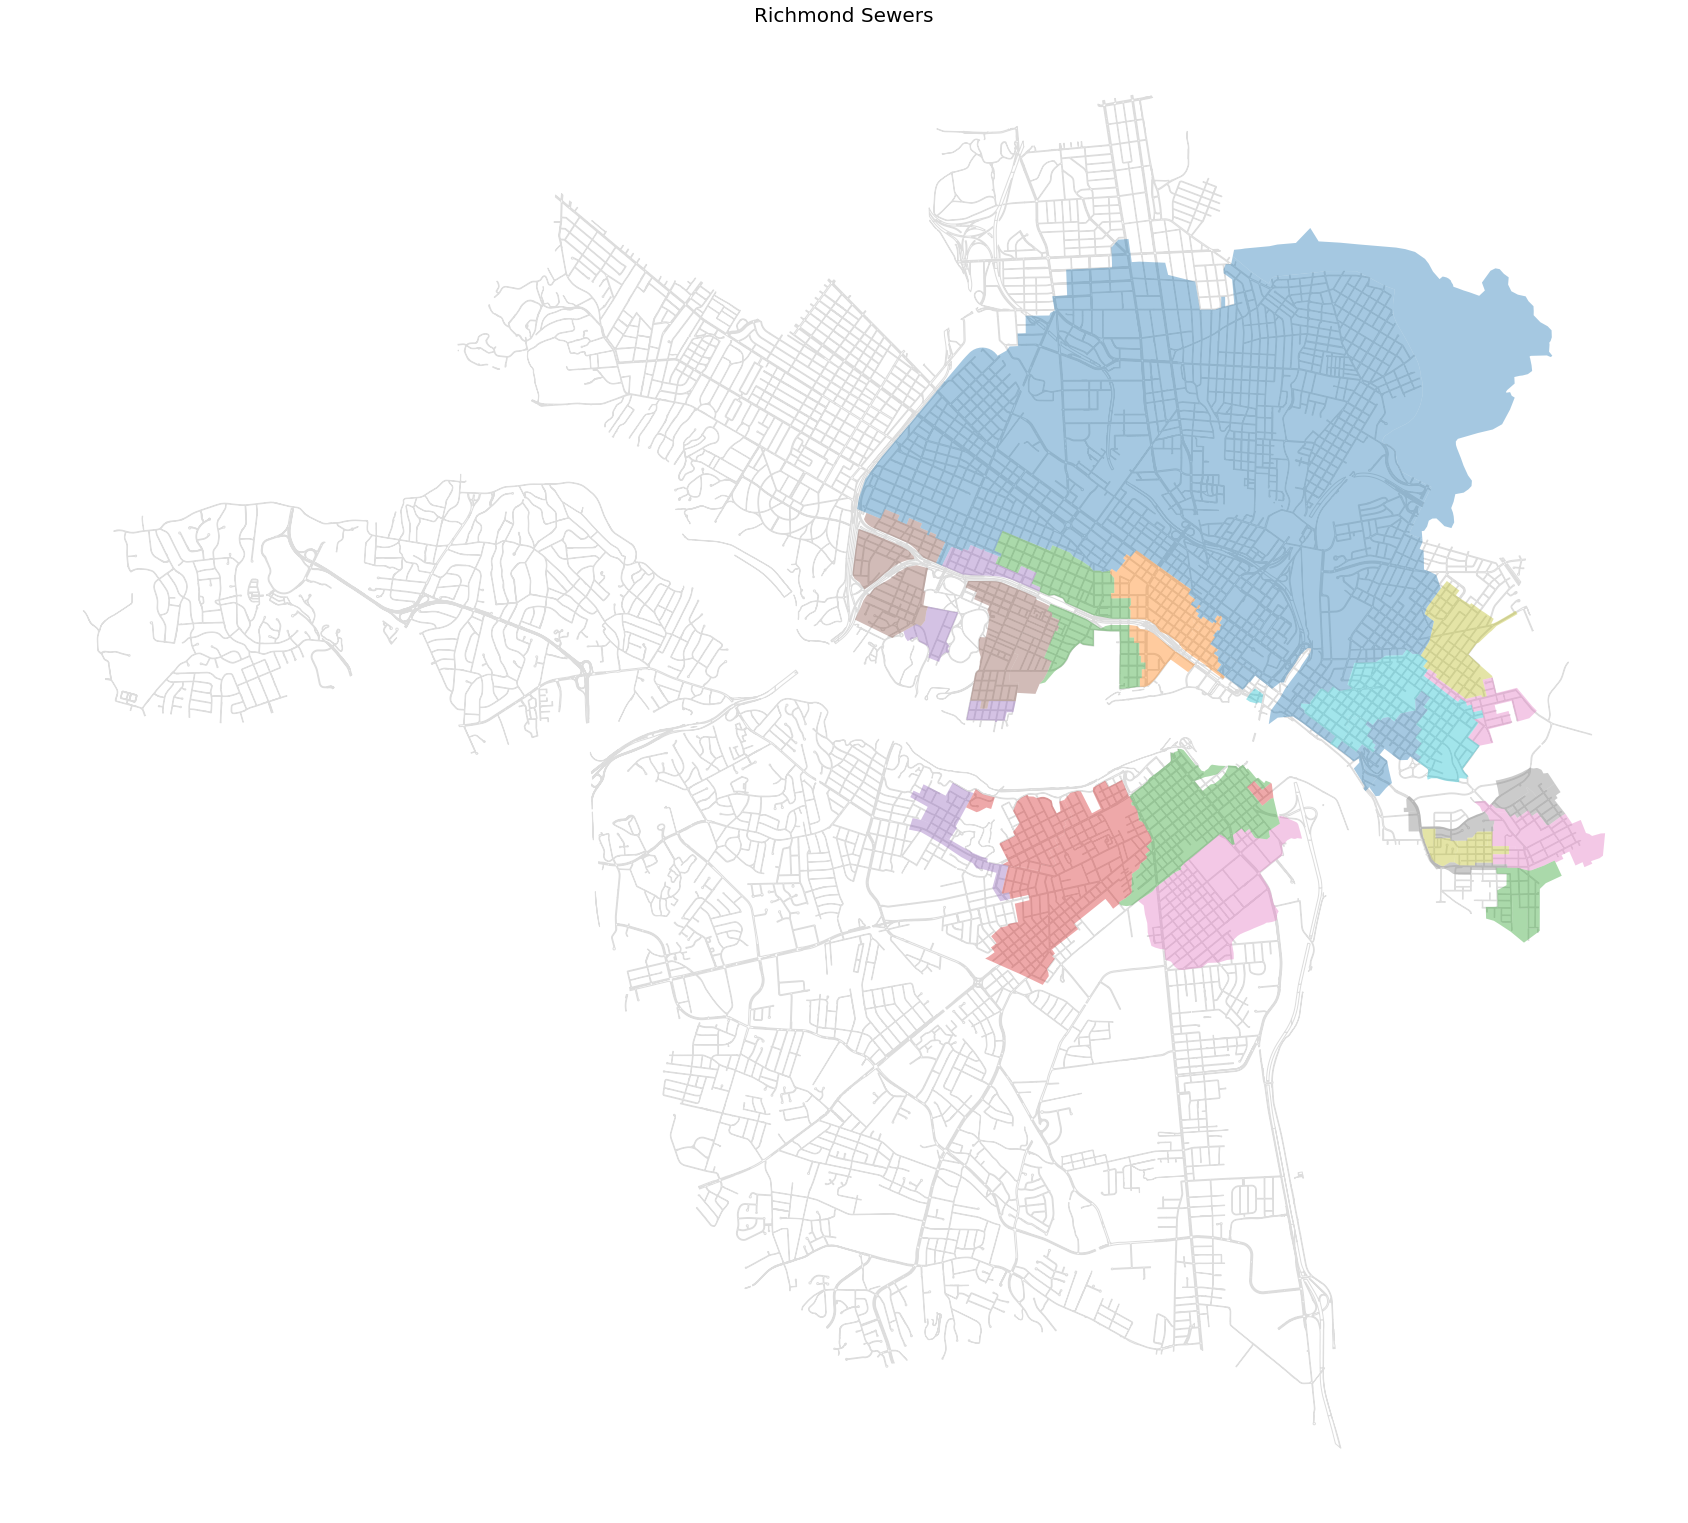

In [13]:
from matplotlib import pyplot as plt
# let's do some plottttts
fig = plt.figure(figsize=(30,30)) # controls resolution - figure size in inches
ax = fig.add_subplot()

# plot a base layer
rvaroads.plot(ax=ax, color='white', edgecolor='#dddddd')

csob.plot("Layer", ax=ax, alpha=0.4)

ax.set_title('Richmond Sewers', fontsize=20)
#plt.legend(handles=splots)

plt.axis('off')

plt.show(fig)
#plt.savefig("pics/sewers.png", facecolor='white', bbox_inches='tight')